<a href="https://colab.research.google.com/github/adit-gudhel/rockpaperscissors/blob/main/Submission_Machine_Learning_Aditya_Nursyahbani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Submission Image Recognition (Batu, Kertas, Gunting)

---


## Program 
Pengenalan gambar yang terdiri dari Kertas, Batu dan Gunting

## Author
Aditya Nursyahbani (aditya.nursyahbani@bppt.go.id)


### Tahap 1. Persiapan Dataset

*   Deklarasi <i>library</i> yang digunakan

In [2]:
import tensorflow as tf
import shutil as su
import zipfile,os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from google.colab import files
from PIL import ImageFile
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras import layers
from keras.models import Sequential

In [3]:
# Memastikan versi tensorflow >= 2
print('Versi TensorFlow: ' + tf.__version__)

Versi TensorFlow: 2.4.1




*   Membuat variabel global



In [4]:
JUMLAH_BATCH = 32
TINGGI = 150
LEBAR = 150
EPOCH = 25
OPTIMIZER = tf.keras.optimizers.RMSprop()



*   Download Dataset



In [5]:
# Download sample dataset rockpaperscissors
!wget --no-check-certificate \
    https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
    -O /tmp/sample.zip

--2021-04-08 15:50:36--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/sample.zip’

/tmp/sample.zip     100%[===================>] 307.92M  7.72MB/s    in 48s     

2021-04-08 15:51:24 (6.39 MB/s) - ‘/tmp/sample.zip’ saved [322873683/322873683]



In [6]:
# Cek file zip hasil download (wget)
print(os.path.isfile('/tmp/sample.zip'))

True




*   Ekstrak file zip (sample.zip)



In [7]:
path_zip = '/tmp/sample.zip'
zip_file = zipfile.ZipFile(path_zip, 'r')
zip_file.extractall('/tmp')
zip_file.close()

# Cek hasil ekstrak
os.listdir('/tmp/rockpaperscissors')

['rps-cv-images', 'paper', 'rock', 'README_rpc-cv-images.txt', 'scissors']



*   Membuat direktori dataset dan membuat subdirektori dataset `train` dan `validation`



In [8]:
# Definisi direktori
base_dir = '/tmp'
name_dir = 'dataset'

ds_dir = os.path.join(base_dir, 'dataset')
train_dir = os.path.join(ds_dir, 'train')
val_dir = os.path.join(ds_dir, 'validation')

train_batu_dir = os.path.join(train_dir, 'batu')
train_gunting_dir = os.path.join(train_dir, 'gunting')
train_kertas_dir = os.path.join(train_dir, 'kertas')

val_batu_dir = os.path.join(val_dir, 'batu')
val_gunting_dir = os.path.join(val_dir, 'gunting')
val_kertas_dir = os.path.join(val_dir, 'kertas')

checkpoint_path = '/tmp/checkpoint_model.h5'

# Hapus direktori dataset jika ada
su.rmtree(ds_dir,ignore_errors=True)

# Hapus file yg tidak digunakan
su.rmtree(base_dir + '/__MACOSX', ignore_errors=True)
os.remove(base_dir + '/sample.zip')

# Cek direktori dataset
cekDataset = os.path.isdir(ds_dir)
if(cekDataset == False):
    os.mkdir(ds_dir)
    os.mkdir(train_dir)
    os.mkdir(val_dir)

In [9]:
# Cek direktori dataset berhasil dibuat
print(os.path.isdir(ds_dir))

True




*   Deklarasi variabel untuk menampung path direktori yang digunakan, copy file dari folder `/tmp/rockpaperscissors` ke direktori `/tmp/dataset` sesuai dengan kategori: batu, kertas, gunting menggunakan `shutil`


In [10]:
# Buat direktori `train` dan `validation` pada direktori `dataset`
data_dir = os.path.join(base_dir, 'rockpaperscissors/rps-cv-images')
data_batu = os.path.join(data_dir, 'rock')
data_kertas = os.path.join(data_dir, 'paper')
data_gunting = os.path.join(data_dir, 'scissors')

# Copy data ke direktori train dan validation
su.copytree(data_batu, train_batu_dir)
su.copytree(data_kertas, train_kertas_dir)
su.copytree(data_gunting, train_gunting_dir)
su.copytree(data_batu, val_batu_dir)
su.copytree(data_kertas, val_kertas_dir)
su.copytree(data_gunting, val_gunting_dir)

'/tmp/dataset/validation/gunting'

In [11]:
print('Total data train batu: ', (len(os.listdir(train_batu_dir))))
print('Total data train kertas: ', (len(os.listdir(train_kertas_dir))))
print('Total data train gunting: ', (len(os.listdir(train_gunting_dir))))
print('Total data vallidation batu: ', (len(os.listdir(val_batu_dir))))
print('Total data validation kertas: ', (len(os.listdir(val_kertas_dir))))
print('Total data validaton gunting: ', (len(os.listdir(val_gunting_dir))))

Total data train batu:  726
Total data train kertas:  712
Total data train gunting:  750
Total data vallidation batu:  726
Total data validation kertas:  712
Total data validaton gunting:  750


### Tahap 2. Data Preprocessing



*   Menggunakan image **data generator** untuk membagi dataset menjadi 2, dataset `train` dan dataset `validation`
*   Mengambil sampel 40% dari total data sample



In [12]:
# Image Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split = 0.4, # membagi / split data 40% dari total sample
    fill_mode='nearest')

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.4)
 
train_generator = train_datagen.flow_from_directory(
     train_dir, 
     target_size=(TINGGI, LEBAR),
     batch_size=JUMLAH_BATCH,
     class_mode='categorical',
     subset='training')
 
val_generator = val_datagen.flow_from_directory(
     val_dir,
     target_size=(TINGGI, LEBAR),
     batch_size=JUMLAH_BATCH,
     class_mode='categorical',
     subset='validation')

print(train_generator.class_indices)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
{'batu': 0, 'gunting': 1, 'kertas': 2}


### Tahap 3. Membuat Model



*   Membuat model sequential menggunakan algoritma CNN



In [13]:
model = Sequential([
    layers.Conv2D(64, (3,3), activation='relu', input_shape=(TINGGI, LEBAR, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile
model.compile(loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [14]:
# Callback untuk mengurangi learning rate ketika nilai val_accuracy menurun
kurangi_learn_rate =  ReduceLROnPlateau(monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.000003)

# Callback untuk menghentikan training ketika nilai val_loss meningkat atau > 0, mencegah overfitting data
stop_training = EarlyStopping(monitor='val_loss', 
    min_delta=0, 
    patience=2, 
    verbose=0, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=False)

# Callback menyimpan state model terbaik
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

### Tahap 4. Melatih Data



*   Melatih data (data training)



In [20]:
# Latih data
history = model.fit(
      train_generator,
      epochs=EPOCH,
      steps_per_epoch=25,
      validation_data=val_generator,
      validation_steps=5,
      verbose=1,
      callbacks=[kurangi_learn_rate, stop_training, checkpoint])

# Buat checkpoint model
model.load_weights(checkpoint_path)

Epoch 1/25
25/25 [==============================] - 55s 2s/step - loss: 0.1930 - accuracy: 0.9364 - val_loss: 0.1028 - val_accuracy: 0.9750
Epoch 2/25
25/25 [==============================] - 55s 2s/step - loss: 0.1632 - accuracy: 0.9429 - val_loss: 0.0832 - val_accuracy: 0.9750
Epoch 3/25
25/25 [==============================] - 58s 2s/step - loss: 0.1577 - accuracy: 0.9481 - val_loss: 0.1278 - val_accuracy: 0.9500

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 4/25
25/25 [==============================] - 57s 2s/step - loss: 0.1332 - accuracy: 0.9625 - val_loss: 0.0620 - val_accuracy: 0.9750
Epoch 5/25
25/25 [==============================] - 57s 2s/step - loss: 0.1231 - accuracy: 0.9600 - val_loss: 0.1376 - val_accuracy: 0.9563

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 6/25
25/25 [==============================] - 57s 2s/step - loss: 0.1147 - accuracy: 0.9588 - val_loss: 0.0594 - val_accuracy: 0.9750

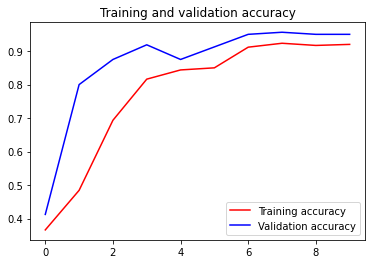

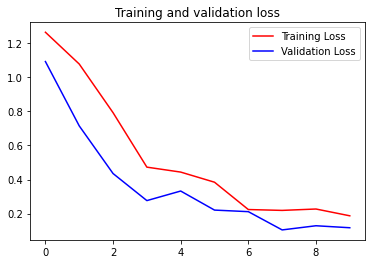

In [16]:
%matplotlib inline
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*  Evaluasi cycle ke 2


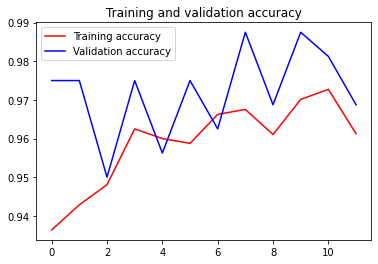

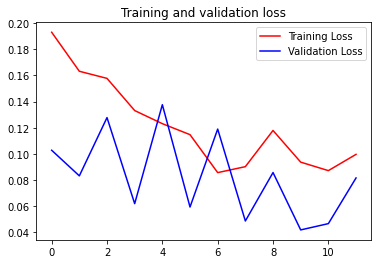

In [21]:
%matplotlib inline
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Tahap 5. Prediksi Data



*   UI Testing



Saving dDtRH0QF7IPSsasH.png to dDtRH0QF7IPSsasH.png
Prediksi image: KERTAS


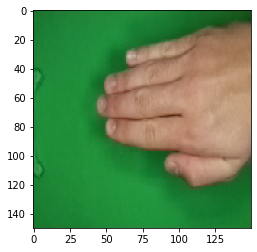

In [22]:
%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True
uploaded = files.upload()
 
for fn in uploaded.keys():
    # prediksi gambar
    path = fn
    img = image.load_img(path, target_size=(TINGGI, LEBAR))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
  
    images = np.vstack([x])
    classes = model.predict(images, batch_size=JUMLAH_BATCH)

    batu     = classes[0][0]
    kertas   = classes[0][2]
    gunting  = classes[0][1]

    if (batu == 1):
       print('Prediksi image: BATU')
    elif (kertas == 1):
       print('Prediksi image: KERTAS')
    elif (gunting == 1):
        print('Prediksi image: GUNTING')
    else:
        print('Tidak dapat memprediksi image\n')
        print('Batu: ', batu, ', Kertas: ', kertas, ', Gunting: ', gunting)